In [1]:
import itertools
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Estimating Power-law Distribution Parameters

Here we want to estimate the $x_{min}$ parameter of a power-law distribution given some total energy input. 

For a total simulation time of $t_{tot}$ and an estimated (i.e. from observations or hydrodynamic scaling laws) time-averaged heating rate $H_n$, the total energy input can be written
$$
H_nt_{tot} = \frac{\tau}{2}\sum_{i=1}^NH_i = \sum_{i=1}^Nq_i.
$$
In this case, $q_i$ is the energy per unit volume injected into the loop by event $i$ such that the heating rate for event $i$ is $H_i=2q_i/\tau$ if we assume triangular pulses of uniform duration $\tau$. 

The event energies are chosen from a power law distribution $p(q)=q^{-\alpha}$ with bounds $(q_a,q_b)$. We will constrain the interval by letting $q_b=\delta q_a$, where $\delta>1$. Thus, our free parameter is $q_a$, the lower bound on the distribution.

In order to construct a distribution under this constraint, we will first compute the distribution with a guess for $q_a$. A reasonable guess might be 
$$
q_a^{(0)} = \varepsilon H_nt_{tot}/N
$$
where $\varepsilon<1$. We can then calculate the parameter
$$
\chi = \frac{H_nt_{tot}}{\sum^N_{i=1}q_i}.
$$
This allows for the update rule $q_a^{t+1}=\chi q_a^{t}$. In this way, we move the interval to lower energies if we have overestimated and to higher energies if we have underestimated.

First, create a function that can accept transform a uniformly distributed variable $x$ to a power-law distributed variable $q$.

In [2]:
np.random.seed()
def pl_dist(alpha,a,b,N):
    x = np.random.rand(N)
    return ((b**(alpha + 1) - a**(alpha+1))*x + a**(alpha+1))**(1/(alpha + 1))

Set all static parameters.

In [3]:
tol = 1e-2
eps = 0.5
max_tries = 1000
H_n = 8.0e-3
ttot = 8e4
tau = 200
total_energy = H_n*ttot*2./tau
delta = 10
alpha = -1.5
tN = np.arange(250,5250,250)
N = np.ceil(ttot/(tN + tau))
n = N[1]

Make a function and construct histograms for all $N$.

In [4]:
def build_dist(num_samples):
    tries = 0
    err = 1.e+300
    safety1 = 0.01
    safety2 = 10
    #Initial guess 
    qa = eps*total_energy/num_samples
    while err > tol and tries <= max_tries:
        #print("Try # %d"%tries)
        #Sample distrubtion
        qi = pl_dist(alpha,qa,qa*delta,int(num_samples))
        #sum
        rhs = np.sum(qi)
        #calculate chi
        chi = total_energy/rhs
        #if chi < safety1 or chi > safety2:
        #    qa = eps*total_energy/num_samples
        #    #print("reset to initial qa guess")
        #    tries += 1
        #    continue
        #update
        qa = chi*qa
        #error
        err = np.fabs(1. - chi)
        #print("error = %f"%err)
        #increment counter
        tries += 1
        
    return qi,tries-1,err
        

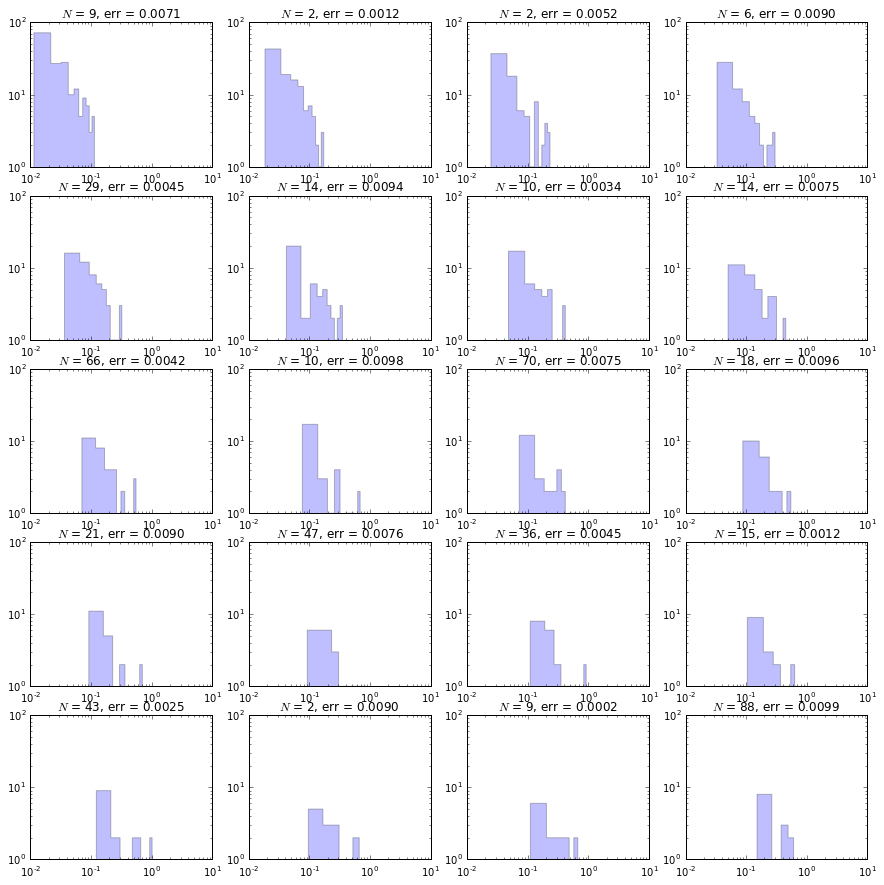

In [5]:
i = 0
err_store = []
iter_store = []
fig,axes = plt.subplots(5,4,figsize=(15,15))
for ax in axes.flatten():
    qs,num_iters,error = build_dist(N[i])
    err_store.append(error)
    iter_store.append(num_iters)
    ax.hist(qs,bins=10,histtype='stepfilled',alpha=0.25)
    ax.set_xlim([0.01,10])
    ax.set_ylim([1,100])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(r'$N$ = %d, err = %.4f'%(num_iters,error))
    i+=1
plt.show()

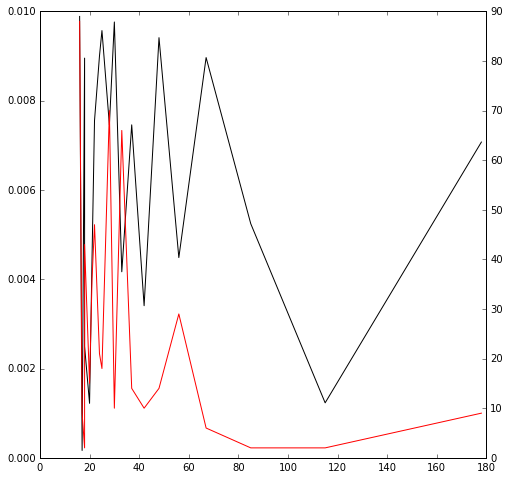

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax2 = ax.twinx()
ax.plot(N,err_store,'k')
ax2.plot(N,iter_store,'r')

Now let's do this in the montecarlo way that we will use it in our EBTEL simulations.

In [7]:
nmc = 1e+4

In [8]:
dists = []
for i in range(len(N)):
    num_runs = int(nmc/N[i])
    temp = []
    print("MC runs for N=%d"%N[i])
    for j in range(num_runs):
        qs,_,_ = build_dist(N[i])
        temp.append(qs)
        
    dists.append(list(itertools.chain(*temp)))

MC runs for N=178
MC runs for N=115
MC runs for N=85
MC runs for N=67
MC runs for N=56
MC runs for N=48
MC runs for N=42
MC runs for N=37
MC runs for N=33
MC runs for N=30
MC runs for N=28
MC runs for N=25
MC runs for N=24
MC runs for N=22
MC runs for N=21
MC runs for N=20
MC runs for N=18
MC runs for N=18
MC runs for N=17
MC runs for N=16


In [9]:
def power_law_curve(x,a,b):
    return a + b*x

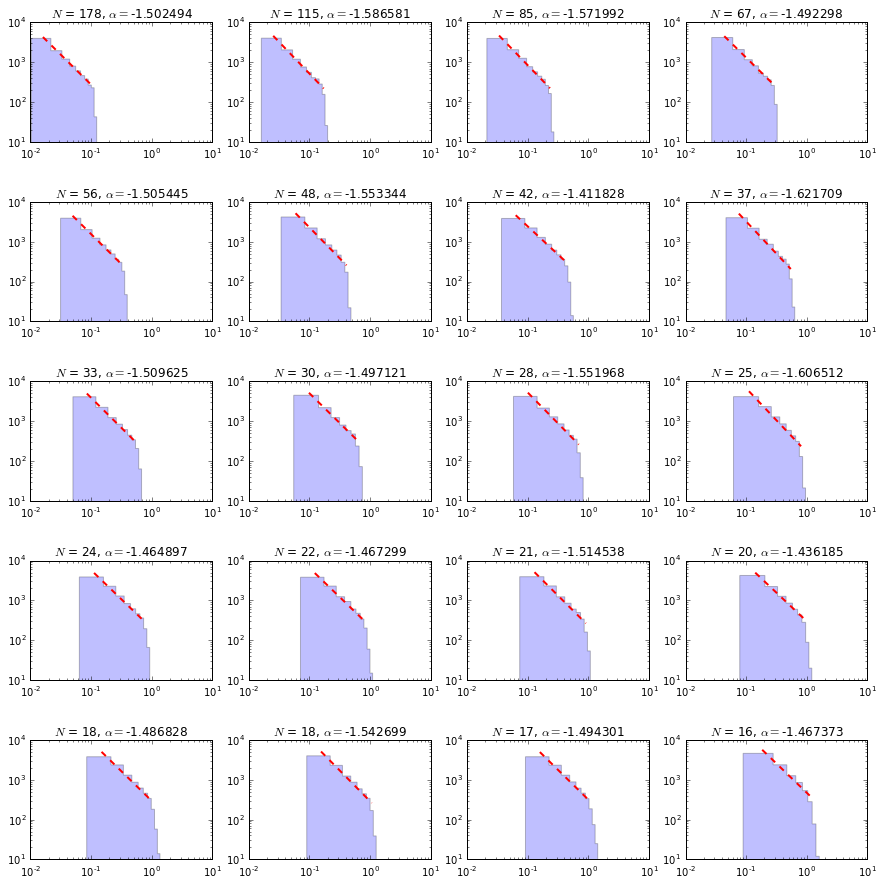

In [10]:
i = 0
fig,axes = plt.subplots(5,4,figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for ax in axes.flatten():
    n,bins,_ = ax.hist(dists[i],bins=10,histtype='stepfilled',alpha=0.25)
    bin_centers = np.log10(np.diff(bins)/2.0+bins[0:-1])
    noise = np.where(n <= 100)
    if len(noise[0]) > 0:
        n = n[0:noise[0][0]]
        bin_centers = bin_centers[0:noise[0][0]]
    pars,covar = curve_fit(power_law_curve,bin_centers,np.log10(n))#,sigma=np.sqrt(np.log10(n)))
    pl_fit = power_law_curve(bin_centers,*pars)
    ax.plot(10**bin_centers,10**pl_fit,'--r',linewidth=2.0)
    ax.set_title(r'$N$ = %d, $\alpha = $%f'%(N[i],pars[1]),fontsize=12)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1e-2,10])
    ax.set_ylim([10,10000])
    i+=1
plt.show()